In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

### Looking at the dataframe and how to impute any missing values

In [2]:
#df_product = pd.read_csv("../order_product.csv")
df = pd.read_csv('../all_merged_data.csv')
#df_product = df_product.merg(df_all, how="left", on="")

In [3]:
df = df[['user_id', 'product_id', 'date_order', 'application_term', 'limit', 
    'result', 'city_id_product', 'bank_id', 'product_type_product', 
    'guarantee_type_product', 'loan_term_min', 'loan_term_max', 'loan_term_type', 
    'decision_cycle', 'loan_cycle', 'repayment_type', 'loan_quota_min', 'loan_quota_max',
    'interest_rate_type', 'guarantee_required', 'standard_type_product', 'apply_num', 
    'fangkuan_num', 'is_p2p', 'id', 'house_register', 'business_license', 'legal_person',
    'married', 'car', 'income', 'house', 'tax', 'socialsecurity', 'bank', 'lifecost', 
    'early_repayment', 'penalty', 'counts']]

In [4]:
df['counts'] = df['counts'].fillna(1)
df = df.fillna(-1)

In [6]:
df = df.groupby(['user_id', 'product_id', 'date_order', 'application_term', 'limit', 
    'result', 'city_id_product', 'bank_id', 'product_type_product', 
    'guarantee_type_product', 'loan_term_min', 'loan_term_max', 'loan_term_type', 
    'decision_cycle', 'loan_cycle', 'repayment_type', 'loan_quota_min', 'loan_quota_max',
    'interest_rate_type', 'guarantee_required', 'standard_type_product', 'apply_num', 
    'fangkuan_num', 'is_p2p', 'id', 'house_register', 'business_license', 'legal_person',
    'married', 'car', 'income', 'house', 'tax', 'socialsecurity', 'bank', 'lifecost', 
    'early_repayment', 'penalty']).agg({'counts':'sum'}).reset_index()

In [7]:
df = df.drop_duplicates()

### Two columns with missing values: early_repayment and penalty
Contingency tables below show there may be a dependence of result on 
the missingness 

In [8]:
df.groupby('early_repayment')['result'].value_counts(normalize=True).\
    rename('values').reset_index().pivot(index='result', columns='early_repayment', 
            values='values').rename(columns={-1:np.nan})

early_repayment,NaN,0.0,1.0
result,,,
0,0.903406,0.873016,0.794402
1,0.096594,0.126984,0.205598


In [9]:
df.groupby('penalty')['result'].value_counts(normalize=True).\
    rename('values').reset_index().pivot(index='result',columns='penalty', 
        values='values').rename(columns={-1:np.nan})

penalty,NaN,0.0,1.0
result,,,
0,0.903158,0.856266,0.781857
1,0.096842,0.143734,0.218143


In [10]:
print((df.apply_num == df.counts).sum(), (df.apply_num != df.counts).sum())

530 142508


### Set up for random forest classifier for "result"

In [11]:
rfc = RandomForestClassifier()

In [22]:
## for the features I drop the categorical variables that seem to hold limited info
features_counts = df.drop(['user_id','product_id','bank_id','city_id_product', 
                           'apply_num', 'result'], axis=1)
results = df['result']

In [13]:
#rfc.set_params(min_samples_leaf=7)
gridparams_rfc = {#'criterion':['gini','entropy'], 
         #      'max_depth': range(16,19,2),        # 13 range(1, 16, 3)    # 16 range(10,17,2)   # 18
               'max_features': range(2,11,2),      #  8 range(4, 10, 2)    # 8 range(6,11,2)     # 6
        #       'min_samples_leaf': range(1,10,4),  #  7 range(1, 10, 3)    # 9 range(5,10,2)     # 7
               'n_estimators': range(20,150,20)}   # 70 range(10, 100, 20) # 70 range(50,101,20) # 80
gridsearch_rfc = GridSearchCV(rfc, gridparams_rfc, cv=5, 
                           scoring='balanced_accuracy', n_jobs=-1)

In [14]:
gridsearch_rfc.fit(features_counts, results)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

{'max_features': 10, 'n_estimators': 140}
0.5793510853447845


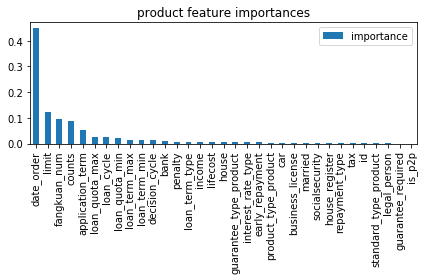

In [15]:
print(gridsearch_rfc.best_params_)
print(gridsearch_rfc.best_score_)
best_est = gridsearch_rfc.best_estimator_
df_features_result_counts = pd.DataFrame(best_est.feature_importances_, 
    index=features_counts.columns, columns=['importance'])
df_features_result_counts.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [17]:
best_est.fit(features_counts, results)
print(best_est.score(features_counts, results))

0.9927921251695354


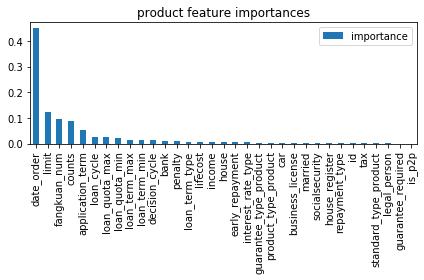

In [19]:
df_features_result_counts2 = pd.DataFrame(best_est.feature_importances_, 
    index=features_counts.columns, columns=['importance'])
df_features_result_counts2.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [20]:
features_applynum = df.drop(['user_id','product_id','bank_id','city_id_product', 
                           'counts', 'result'], axis=1)

In [23]:
gridsearch_rfc.fit(features_applynum, results)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

{'max_features': 10, 'n_estimators': 100}
0.5846636649937703


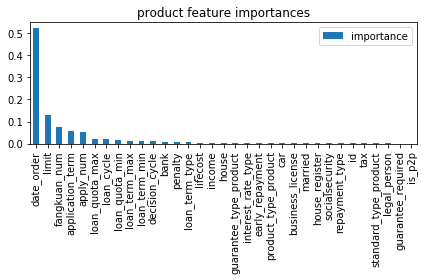

In [24]:
print(gridsearch_rfc.best_params_)
print(gridsearch_rfc.best_score_)
best_est = gridsearch_rfc.best_estimator_
df_features_result_applynum = pd.DataFrame(best_est.feature_importances_, 
    index=features_applynum.columns, columns=['importance'])
df_features_result_applynum.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [25]:
best_est.fit(features_applynum, results)
print(best_est.score(features_applynum, results))

0.9888491170178554


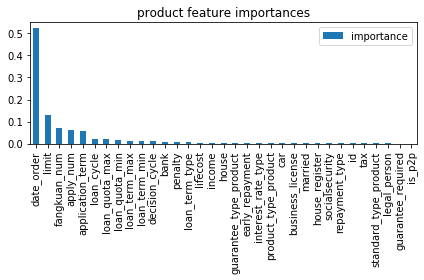

In [27]:
df_features_result_applynum2 = pd.DataFrame(best_est.feature_importances_, 
    index=features_applynum.columns, columns=['importance'])
df_features_result_applynum2.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

## Random Forest to determine Apply_num

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
## for the features I drop the categorical variables that seem to hold limited info
features = df.drop(['user_id','product_id','bank_id','city_id_product', 
                           'apply_num', 'counts'], axis=1)
counts_target = df['counts']
applynum_target = df['apply_num']

In [35]:
rfr = RandomForestRegressor()

In [38]:
np.arange(60,300,30)

array([ 60,  90, 120, 150, 180, 210, 240, 270])

In [39]:
gridparams_rfr = {#'criterion':['gini','entropy'], 
         #      'max_depth': range(16,19,2),        # 13 range(1, 16, 3)    # 16 range(10,17,2)   # 18
               'max_features': range(2,11,2),      #  8 range(4, 10, 2)    # 8 range(6,11,2)     # 6
        #       'min_samples_leaf': range(1,10,4),  #  7 range(1, 10, 3)    # 9 range(5,10,2)     # 7
               'n_estimators': range(60,300,30)}   # 70 range(10, 100, 20) # 70 range(50,101,20) # 80
gridsearch_rfr = GridSearchCV(rfr, gridparams_rfr, cv=5, 
                           scoring='r2', n_jobs=-1)

In [40]:
gridsearch_rfr.fit(features, counts_target)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_features': range(2, 11, 2),


{'max_features': 6, 'n_estimators': 40}
-0.18383023038147345


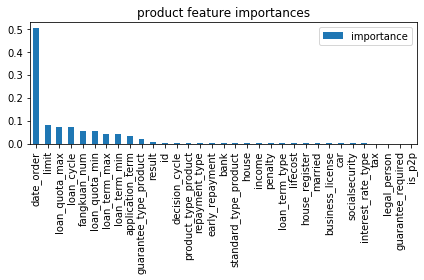

In [41]:
print(gridsearch_rfr.best_params_)
print(gridsearch_rfr.best_score_)
best_est = gridsearch_rfr.best_estimator_
df_rfr_counts = pd.DataFrame(best_est.feature_importances_, 
    index=features.columns, columns=['importance'])
df_rfr_counts.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [43]:
best_est.fit(features, counts_target)
print(best_est.score(features, counts_target)) # 8 range(2,10,1), 250 range(100,301,50)

0.8419287441066122


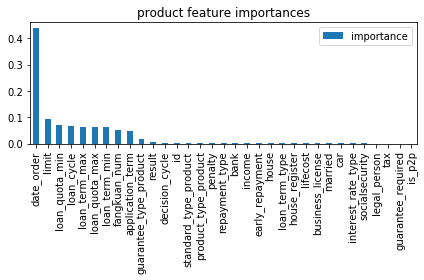

In [44]:
df_rfr_counts2 = pd.DataFrame(best_est.feature_importances_, 
    index=features.columns, columns=['importance'])
df_rfr_counts2.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [45]:
gridsearch_rfr.fit(features, applynum_target)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_features': range(2, 11, 2),


{'max_features': 10, 'n_estimators': 100}
0.999967897091937


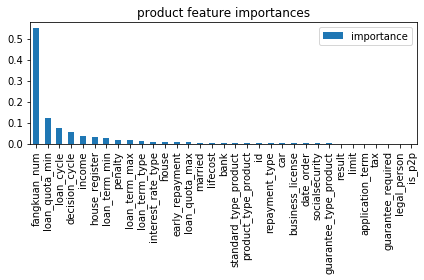

In [46]:
print(gridsearch_rfr.best_params_)
print(gridsearch_rfr.best_score_)
best_est = gridsearch_rfr.best_estimator_
df_rfr_applynum = pd.DataFrame(best_est.feature_importances_, 
    index=features.columns, columns=['importance'])
df_rfr_applynum.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

In [47]:
best_est.fit(features, applynum_target)
print(best_est.score(features, applynum_target))

0.9999945355858079


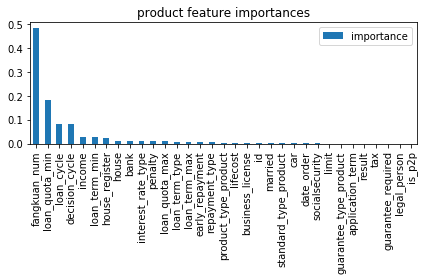

In [48]:
df_rfr_applynum2 = pd.DataFrame(best_est.feature_importances_, 
    index=features.columns, columns=['importance'])
df_rfr_applynum2.sort_values(by='importance', ascending=False).plot.bar()
plt.title('product feature importances')
plt.tight_layout()
plt.show()

### Clustering

In [49]:
from sklearn.cluster import KMeans

In [50]:
kmeans = KMeans()

                          counts  counts_bestest  applynum  applynum_bestest
date_order              0.502555        0.438470  0.001238          0.001752
limit                   0.082872        0.091991  0.000183          0.000171
loan_quota_max          0.073994        0.064417  0.006024          0.008693
loan_cycle              0.070188        0.065841  0.074037          0.080635
fangkuan_num            0.053836        0.049840  0.549711          0.483375
loan_quota_min          0.053167        0.072298  0.123942          0.183516
loan_term_max           0.043198        0.064561  0.017158          0.006557
loan_term_min           0.043180        0.061919  0.025881          0.025434
application_term        0.033569        0.048815  0.000083          0.000090
guarantee_type_product  0.018986        0.016763  0.000238          0.000168
result                  0.005612        0.007095  0.000183          0.000072
id                      0.003163        0.002163  0.002714          0.002844

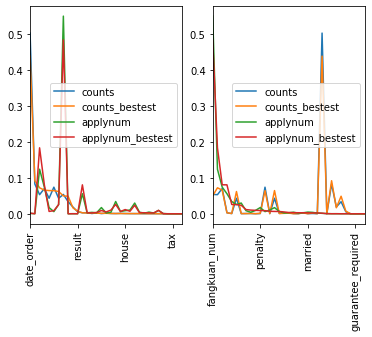

In [76]:
feature_importances = pd.concat([df_rfr_counts.rename(columns={"importance":"counts"}), 
                        df_rfr_counts2.rename(columns={"importance":"counts_bestest"}), 
                        df_rfr_applynum.rename(columns={"importance":"applynum"}), 
                        df_rfr_applynum2.rename(columns={"importance":
                                            "applynum_bestest"})], axis=1)

f, (ax1, ax2) = plt.subplots(1, 2)
feature_importances.sort_values(by="counts_bestest", ascending=False).plot(ax = ax1)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
feature_importances.sort_values(by="applynum_bestest", ascending=False).plot(ax=ax2)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)
print(feature_importances.sort_values(by="counts", ascending=False))
print(feature_importances.sort_values(by="applynum", ascending=False))

In [216]:
features_counts = df[feature_importances.sort_values(by="counts_bestest", 
                    ascending=False)[:15].index.tolist() + ['counts']]
features_applynum = df[feature_importances.sort_values(by="applynum_bestest", 
                    ascending=False)[:15].index.tolist() + ['apply_num']]

In [217]:
for column in features_counts.columns:
    print(column)
    if (features_counts[column].nunique() < 10) and (features_counts[column].nunique() > 2):
        print(features_counts[column].value_counts())
        features_counts = pd.concat([features_counts, 
                pd.get_dummies(features_counts[column], prefix=column)], axis=1)

date_order
limit
loan_quota_min
loan_cycle
loan_term_max
loan_quota_max
loan_term_min
fangkuan_num
application_term
guarantee_type_product
2    120181
1     14804
4      5082
3      1256
6      1194
0       280
5       241
Name: guarantee_type_product, dtype: int64
result
decision_cycle
id
standard_type_product
product_type_product
6      90690
100    29905
1      16581
5       3062
3       1762
2        633
4        356
102       29
101       20
Name: product_type_product, dtype: int64
counts


In [218]:
for column in features_applynum.columns:
    print(column)
    if (features_applynum[column].nunique() < 10) and \
    (features_applynum[column].nunique() > 2):
        print(features_applynum[column].value_counts())
        
        features_applynum = pd.concat([features_applynum, 
                pd.get_dummies(features_applynum[column], prefix=column)], axis=1)

fangkuan_num
loan_quota_min
loan_cycle
decision_cycle
income
loan_term_min
house_register
house
bank
interest_rate_type
0    126245
2     16714
1        79
Name: interest_rate_type, dtype: int64
penalty
 1.0    80383
-1.0    46354
 0.0    16301
Name: penalty, dtype: int64
loan_quota_max
loan_term_type
loan_term_max
early_repayment
 1.0    96684
-1.0    45976
 0.0      378
Name: early_repayment, dtype: int64
apply_num


In [94]:
from sklearn.preprocessing import StandardScaler

In [222]:
counts_matrix = StandardScaler().fit_transform(features_counts.\
                    drop(['guarantee_type_product','product_type_product'], axis=1))
applynum_matrix = StandardScaler().fit_transform(features_applynum.\
                    drop(['early_repayment','interest_rate_type','penalty'], axis=1))

In [97]:
def plot_inertia(km, X, n_cluster_range):
    inertias = []
    for i in n_cluster_range:
        km.set_params(n_clusters=i)
        km.fit(X)
        inertias.append(km.inertia_)
    plt.plot(n_cluster_range, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

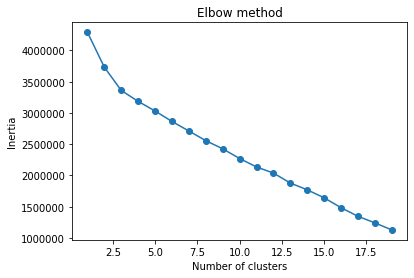

In [98]:
plot_inertia(kmeans, counts_matrix, range(1,20))

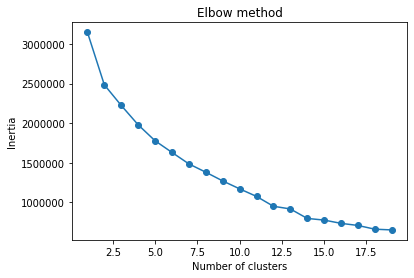

In [99]:
plot_inertia(kmeans, applynum_matrix, range(1,20))

kmeans3 = KMeans().set_params(n_clusters=3)

In [102]:
kmeans3.fit(counts_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [106]:
pd.Series(kmeans3.labels_).value_counts()

0    98835
1    29839
2    14364
dtype: int64

In [223]:
group0 = features_counts.iloc[kmeans3.labels_ == 0, :]
group1 = features_counts.iloc[kmeans3.labels_ == 1, :]
group2 = features_counts.iloc[kmeans3.labels_ == 2, :]

In [224]:
pd.concat([group0.mean(), group1.mean(), group2.mean()], axis=1).\
    sort_values(by=0).round(decimals=2)

,0,1,2
product_type_product_102,0.00,0.00,0.00
product_type_product_100,0.00,1.00,0.01
product_type_product_5,0.00,0.00,0.21
guarantee_type_product_0,0.00,0.00,0.02
product_type_product_101,0.00,0.00,0.00
guarantee_type_product_6,0.00,0.02,0.04
guarantee_type_product_3,0.00,0.01,0.06
guarantee_type_product_5,0.00,0.01,0.00
product_type_product_4,0.00,0.00,0.01
guarantee_type_product_1,0.00,0.07,0.86


In [225]:
pd.concat([group0.median(), group1.median(), group2.median()], axis=1).\
    sort_values(by=0).round(decimals=2)

,0,1,2
product_type_product_102,0.0,0.0,0.0
guarantee_type_product_4,0.0,0.0,0.0
guarantee_type_product_3,0.0,0.0,0.0
guarantee_type_product_1,0.0,0.0,1.0
guarantee_type_product_0,0.0,0.0,0.0
product_type_product_101,0.0,0.0,0.0
product_type_product_1,0.0,0.0,0.0
guarantee_type_product_5,0.0,0.0,0.0
result,0.0,0.0,0.0
guarantee_type_product_6,0.0,0.0,0.0


In [236]:
features_counts['kmeans_group'] = kmeans3.labels_

In [152]:
numerical_col = []
for column in features_counts.columns:
    print(column)
    print(features_counts[column].nunique())
    if features_counts[column].nunique() > 10:
        numerical_col.append(column)

date_order
793
limit
420
loan_quota_min
42
loan_cycle
42
loan_term_max
55
loan_quota_max
77
loan_term_min
18
fangkuan_num
312
application_term
60
result
2
decision_cycle
17
id
2
standard_type_product
2
counts
287
guarantee_type_product_0
2
guarantee_type_product_1
2
guarantee_type_product_2
2
guarantee_type_product_3
2
guarantee_type_product_4
2
guarantee_type_product_5
2
guarantee_type_product_6
2
product_type_product_1
2
product_type_product_2
2
product_type_product_3
2
product_type_product_4
2
product_type_product_5
2
product_type_product_6
2
product_type_product_100
2
product_type_product_101
2
product_type_product_102
2
kmeans_group
3


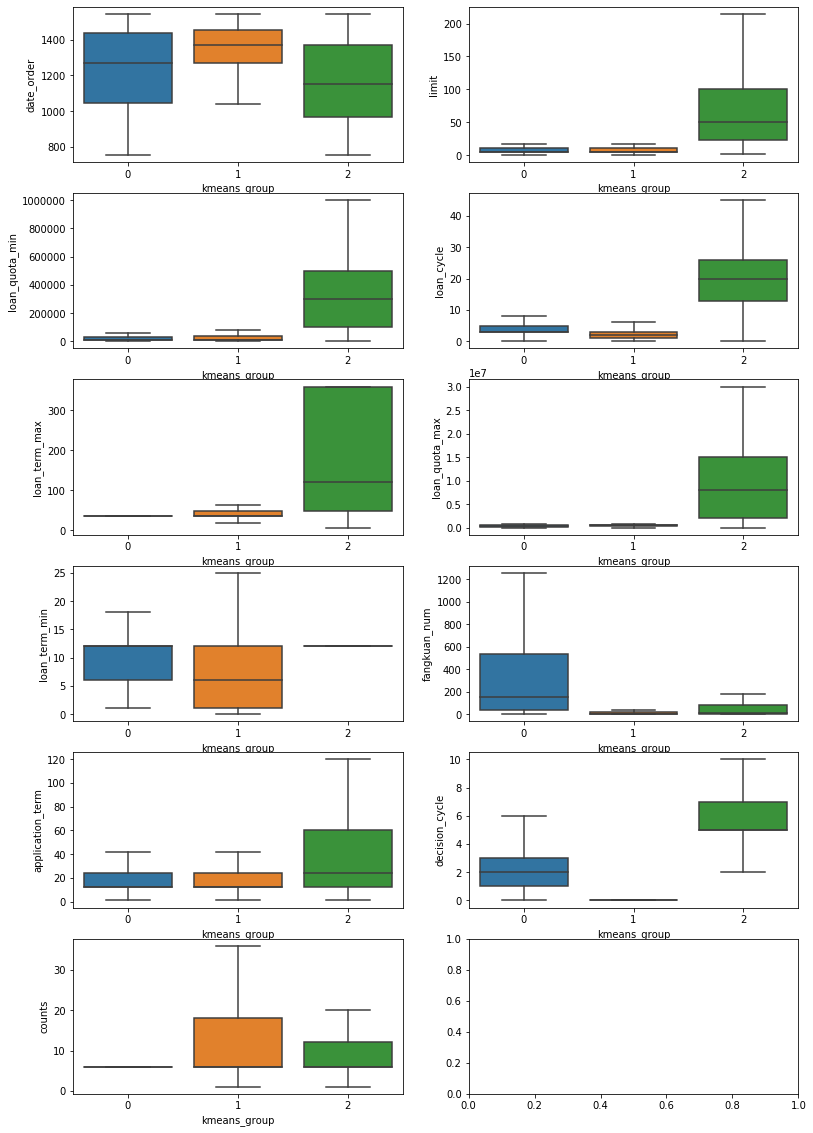

In [268]:
f, axes = plt.subplots(6,2, figsize=(13, 20))
for i, column in enumerate(numerical_col):
    sns.boxplot(x='kmeans_group', y=column, data=features_counts, 
                ax=axes[i//2][i%2], showfliers=False)
    

In [258]:
import seaborn as sns

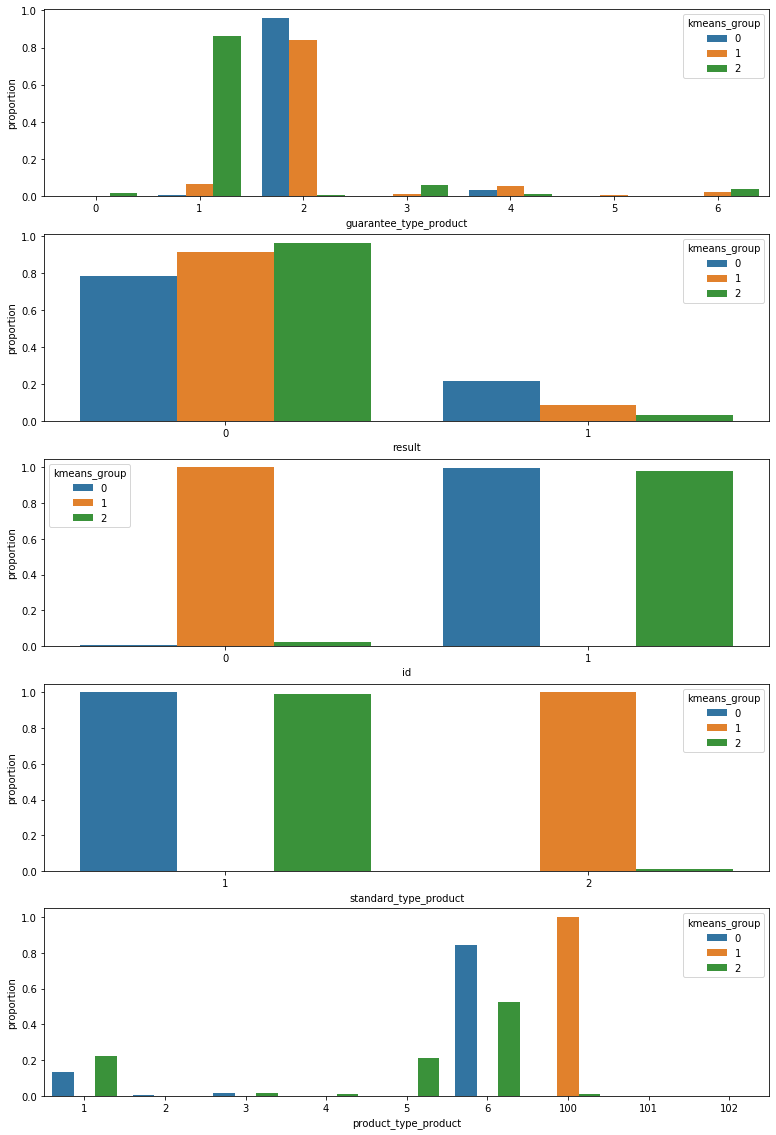

In [262]:
f, axes = plt.subplots(5,1, figsize=(13, 20))
for i, column in enumerate(['guarantee_type_product', 'result', 'id',
                            'standard_type_product', 'product_type_product']):
    plotdf = features_counts.groupby('kmeans_group')[column].\
        value_counts(normalize=True).rename('proportion').reset_index()
    sns.barplot(x=column, y= 'proportion', hue='kmeans_group', data = plotdf, ax=axes[i])#.plot.bar(ax=axes[i])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15f76ddd0>,
      dtype=object)

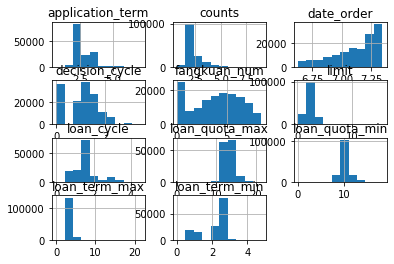

In [283]:
#from sklearn.cluster import AgglomerativeClustering
#hier = AgglomerativeClustering()
np.log1p(features_counts[numerical_col]).hist()

In [284]:
numerical_col

['date_order',
 'limit',
 'loan_quota_min',
 'loan_cycle',
 'loan_term_max',
 'loan_quota_max',
 'loan_term_min',
 'fangkuan_num',
 'application_term',
 'decision_cycle',
 'counts']

In [286]:
transformed_features = features_counts.copy()
transformed_features['date_order'] = transformed_features['date_order']**3
transformed_features[numerical_col[1:]] = np.log1p(transformed_features[numerical_col[1:]])

In [287]:
transformed_features

,date_order,limit,loan_quota_min,loan_cycle,loan_term_max,loan_quota_max,loan_term_min,fangkuan_num,application_term,guarantee_type_product,...,product_type_product_1,product_type_product_2,product_type_product_3,product_type_product_4,product_type_product_5,product_type_product_6,product_type_product_100,product_type_product_101,product_type_product_102,kmeans_group
0,2087336952,3.583519,9.210440,1.386294,3.610918,13.122365,1.386294,2.772589,3.610918,2,...,0,0,0,0,0,0,1,0,0,1
1,1911240521,1.791759,9.210440,1.098612,3.610918,11.918397,0.693147,0.000000,1.945910,2,...,1,0,0,0,0,0,0,0,0,0
2,967361669,3.931826,10.819798,1.791759,3.610918,13.122365,1.386294,7.755767,3.610918,2,...,0,0,0,0,0,1,0,0,0,0
3,967361669,3.044522,10.819798,1.791759,3.891820,13.122365,1.945910,0.000000,3.610918,2,...,0,0,0,0,0,1,0,0,0,0
4,2363266368,1.386294,9.903538,0.693147,3.610918,13.122365,1.098612,1.098612,3.610918,2,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143033,3163575232,3.931826,13.122365,3.135494,4.795791,16.523561,2.564949,6.202536,4.795791,1,...,0,0,0,0,0,1,0,0,0,2
143034,1184287112,2.397895,8.987322,1.386294,3.891820,12.611541,2.564949,6.329721,3.891820,2,...,0,0,0,0,0,1,0,0,0,0
143035,748613312,1.791759,9.105091,1.386294,3.891820,13.122365,1.945910,0.000000,2.564949,2,...,0,0,0,0,0,1,0,0,0,0
143036,2610969633,1.791759,9.903538,1.791759,3.610918,12.611541,2.564949,5.351858,3.610918,2,...,0,0,0,0,0,1,0,0,0,0


In [288]:
transformed_matrix = StandardScaler().fit_transform(transformed_features.\
                    drop(['guarantee_type_product','product_type_product'], axis=1))

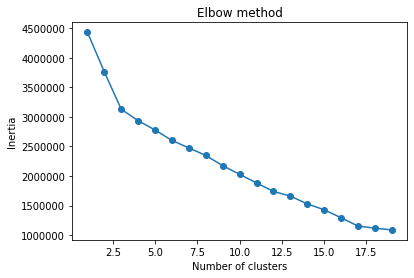

In [289]:
plot_inertia(kmeans, transformed_matrix, range(1,20))

In [291]:
kmeans3_transform = KMeans().set_params(n_clusters=3)

In [292]:
kmeans3_transform.fit(transformed_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [293]:
features_counts['kmeans_group_transform'] = kmeans3_transform.labels_

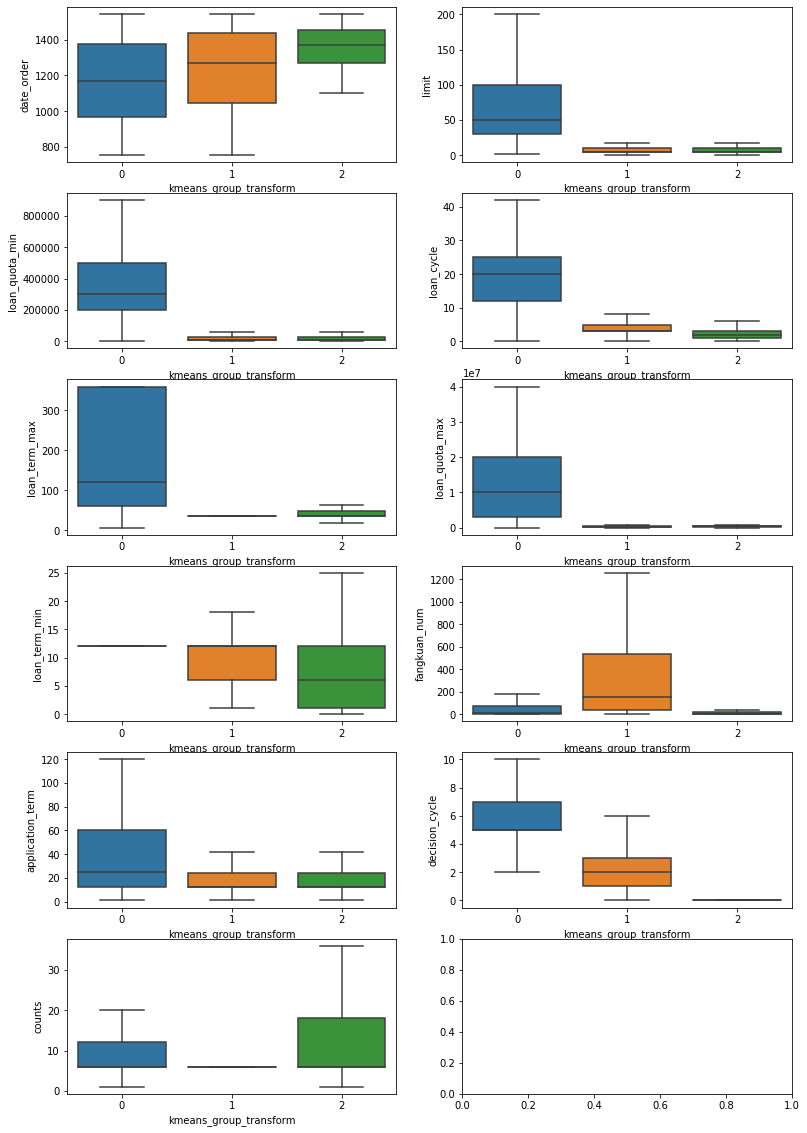

In [294]:
f, axes = plt.subplots(6,2, figsize=(13, 20))
for i, column in enumerate(numerical_col):
    sns.boxplot(x='kmeans_group_transform', y=column, data=features_counts, 
                ax=axes[i//2][i%2], showfliers=False)

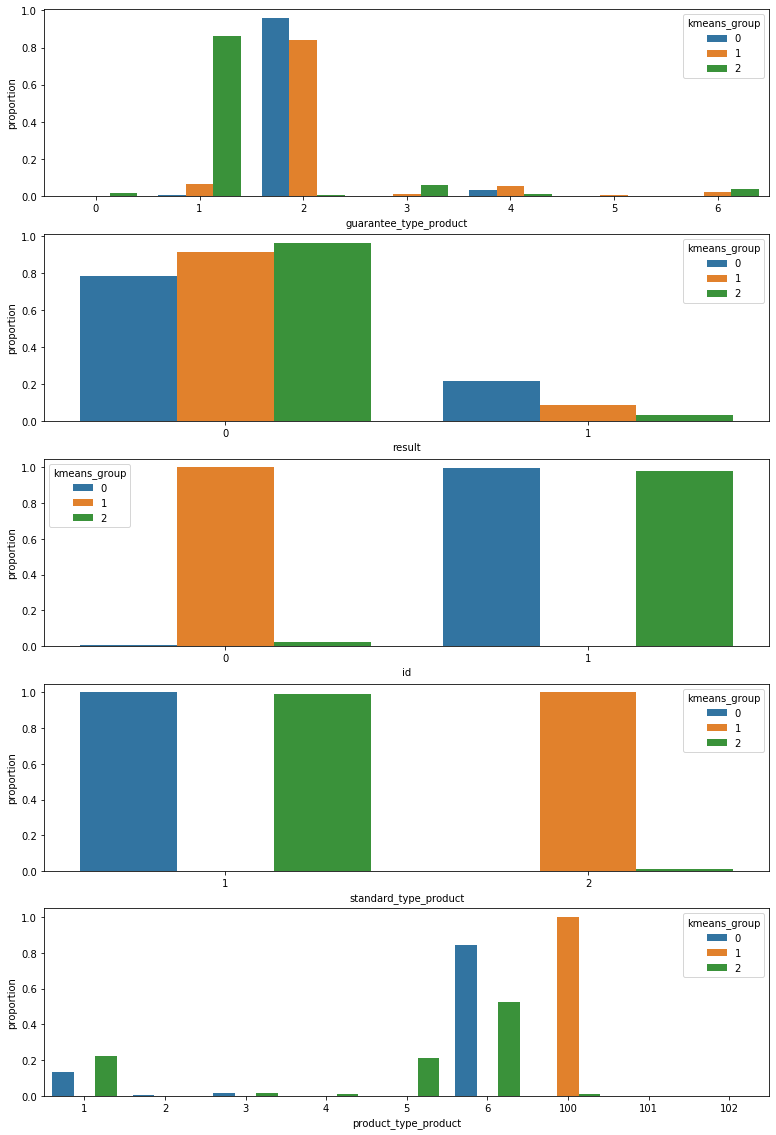

In [295]:
f, axes = plt.subplots(5,1, figsize=(13, 20))
for i, column in enumerate(['guarantee_type_product', 'result', 'id',
                            'standard_type_product', 'product_type_product']):
    plotdf = features_counts.groupby('kmeans_group')[column].\
        value_counts(normalize=True).rename('proportion').reset_index()
    sns.barplot(x=column, y= 'proportion', hue='kmeans_group', data = plotdf, ax=axes[i])#.plot.bar(ax=axes[i])
